# Air Quality Forecasts
The CAMS service provides the [Air Quality Forecasts for Europe](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts). The data product is based on an ensemble of the outputs of nine Earth System models that provides the forecasts for many polluttants such as NOx, Ozone, particulate matter (PM2.5 and PM10) and SO2. In this experiment we want to retrieve the forecasts for NO2 over the Italian peninsula for the next three days and visualize the forecasts as a sequence in a GIF.

In [7]:
import xarray as xr
import pandas as pd
import numpy as np
import cdsapi
from platform import python_version
print("python version: %s"%python_version())
print("pandas version: %s"%pd.__version__)
print("xarray version: %s"%xr.__version__)

python version: 3.8.2
pandas version: 1.0.2
xarray version: 0.14.0


In [8]:
#URL = "https://ads.atmosphere.copernicus.eu/api/v2"
#KEY = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
#c = cdsapi.Client(url=URL, key=KEY)

c = cdsapi.Client()

c.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'model': 'ensemble',
        'date': '2020-11-30/2020-12-02',
        'format': 'netcdf',
        'variable': 'nitrogen_dioxide',
        'level': [
            '0', '50', '250',
            '500',
        ],
        'type': 'forecast',
        'time': '00:00',
        'leadtime_hour': [
            '24', '48', '72',
        ],
        'area': [
            47.12, 6.57, 36.4,
            18.52,
        ],
    },
    'data/air_quality_forecasts_europe_20201130-3days.zip')

2020-12-02 23:54:57,438 INFO Welcome to the CDS
2020-12-02 23:54:57,444 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2020-12-02 23:54:57,541 INFO Request is queued
2020-12-02 23:54:58,620 INFO Request is running
2020-12-02 23:55:06,018 INFO Request is completed
2020-12-02 23:55:06,025 INFO Downloading http://136.156.133.70/cache-compute-0001/cache/data4/adaptor.cams_regional_fc.retrieve-1606946105.3685718-30859-3-8ac25e84-3adf-41b5-a188-4c0015780a1d.zip to data/air_quality_forecasts_europe_20201130-3days.zip (1.8M)
2020-12-02 23:55:06,792 INFO Download rate 2.3M/s   


Result(content_length=1840426,content_type=application/zip,location=http://136.156.133.70/cache-compute-0001/cache/data4/adaptor.cams_regional_fc.retrieve-1606946105.3685718-30859-3-8ac25e84-3adf-41b5-a188-4c0015780a1d.zip)

The webservice sends the response as a zip file that contains netCDF files 

In [9]:
import zipfile
with zipfile.ZipFile('data/air_quality_forecasts_europe_20201130-3days.zip', 'r') as zip_ref:
    zip_ref.extractall('data/aq_forecasts/20201130')

In [10]:
!ls data/aq_forecasts/20201130

ENS_FORECAST_2020-11-30.nc
ENS_FORECAST_2020-12-01.nc
ENS_FORECAST_2020-12-02.nc


Let's examine one file, the first forecast

In [70]:
forecast1_ds = xr.open_dataset('data/aq_forecasts/20201130/ENS_FORECAST_2020-11-30.nc')
forecast1_ds

<xarray.Dataset>
Dimensions:    (latitude: 107, level: 4, longitude: 119, time: 3)
Coordinates:
  * longitude  (longitude) float32 6.65 6.75 6.85 6.95 ... 18.25 18.35 18.45
  * latitude   (latitude) float32 47.05 46.95 46.85 46.75 ... 36.65 36.55 36.45
  * level      (level) float32 0.0 50.0 250.0 500.0
  * time       (time) timedelta64[ns] 1 days 2 days 3 days
Data variables:
    no2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2 Air Pollutant FORECAST at 4 levels
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20201130+[24H_72H]
    summary:      ENSEMBLE model hourly FORECAST of NO2 concentration at 4 le...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

The 1st day forecasts for NO2 are in the 'no2_conc' variable. We put the data in memory and close the file.  

In [29]:
no2_f1 = forecast1_ds['no2_conc']
#forecast1_ds.close()
no2_f1

<xarray.DataArray 'no2_conc' (time: 3, level: 4, latitude: 107, longitude: 119)>
[152796 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 6.65 6.75 6.85 6.95 ... 18.25 18.35 18.45
  * latitude   (latitude) float32 47.05 46.95 46.85 46.75 ... 36.65 36.55 36.45
  * level      (level) float32 0.0 50.0 250.0 500.0
  * time       (time) timedelta64[ns] 1 days 2 days 3 days
Attributes:
    species:        Nitrogen Dioxide
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_nitrogen_dioxide_in_air

We select the forecasts for NO2 at ground level

In [94]:
no2_f1_lev0 = no2_f1.sel(level = 0.0) # filter level 0.0
no2_f1_lev0.shape

(3, 107, 119)

As we can see from the description, the time interval of each forecast is provided as a delta in nanoseconds (ns), from the first day to the second day, that is 86400 nanoseconds, then from the first day to the third and so on.

In [98]:
no2_f1_lev0_1 = no2_f1_lev0.sel(time = '86400000000000')
no2_f1_lev0_1.shape

(107, 119)

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
print("matplotlib version: %s"%matplotlib.__version__)
print("cartopy version: %s"%cartopy.__version__)

matplotlib version: 3.3.1
cartopy version: 0.18.0


Text(0.5, 1.0, 'Air Quality Forecast - 2020-11-30T00:00:00')

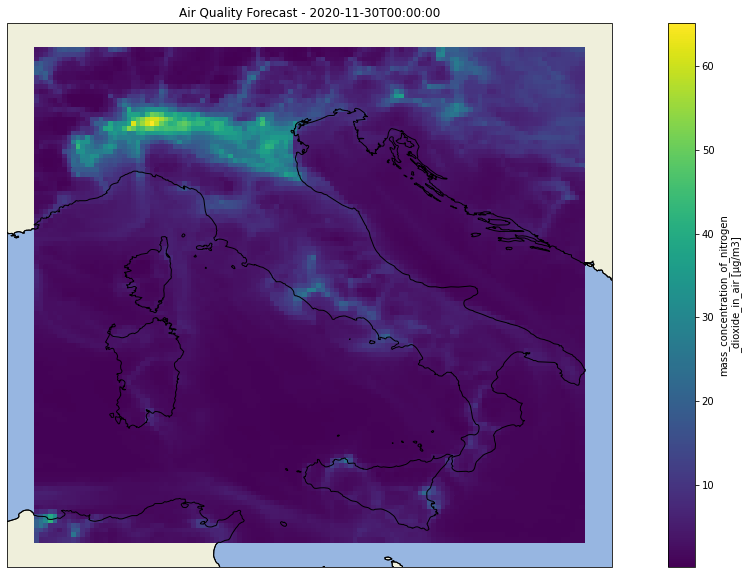

In [100]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.coastlines()
#no2_f1.sel(level = 0.0, time='86400000000000').plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='viridis')
no2_f1_lev0_1.plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='viridis')
plt.title('Air Quality Forecast - 2020-11-30T00:00:00')